# Segmentacion manual

Dimensiones del volumen de imagen: (448, 448, 160)
Dimensiones del volumen de máscara: (448, 448, 160)


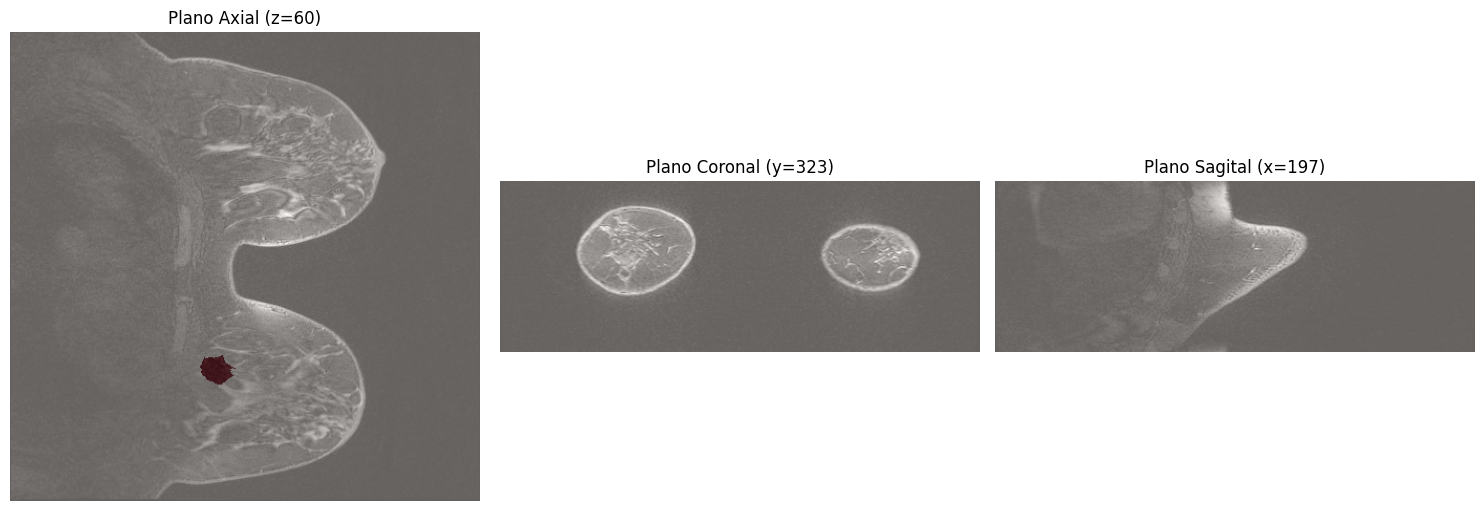

Usando semilla en (323, 196, 57) con valor 0.1191
Umbrales: [0.0191, 0.2191]
Iniciando segmentación 3D...
Tiempo límite alcanzado (30s)
Segmentación completada. Volumen: 122269 voxels


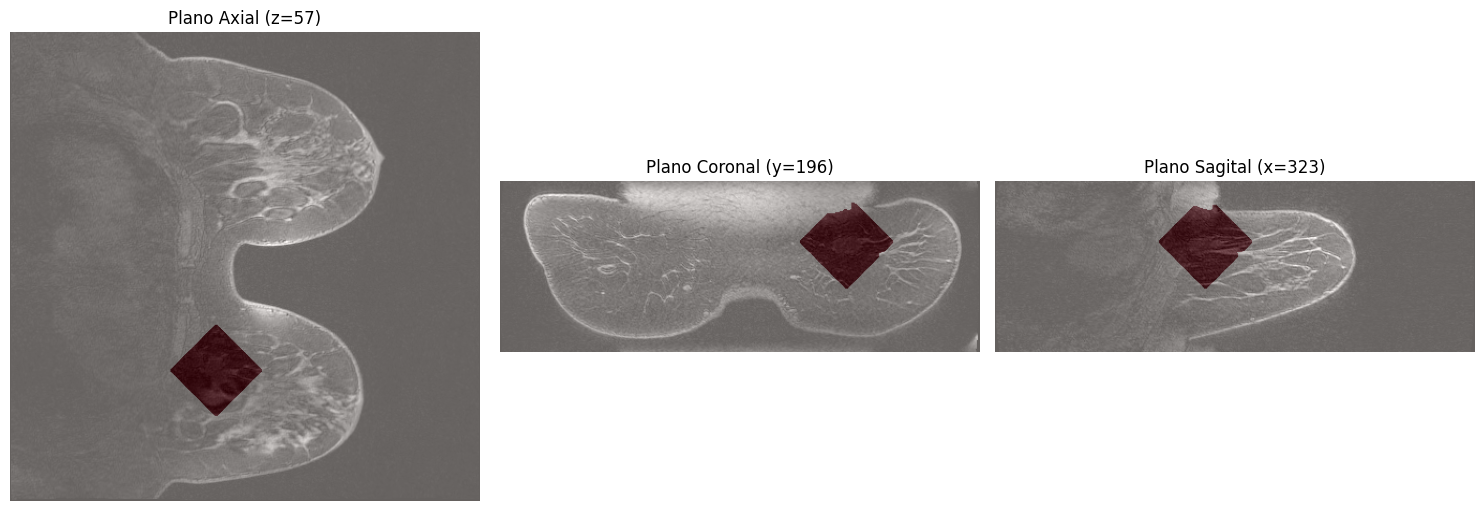

Generando visualización 3D de la máscara real...


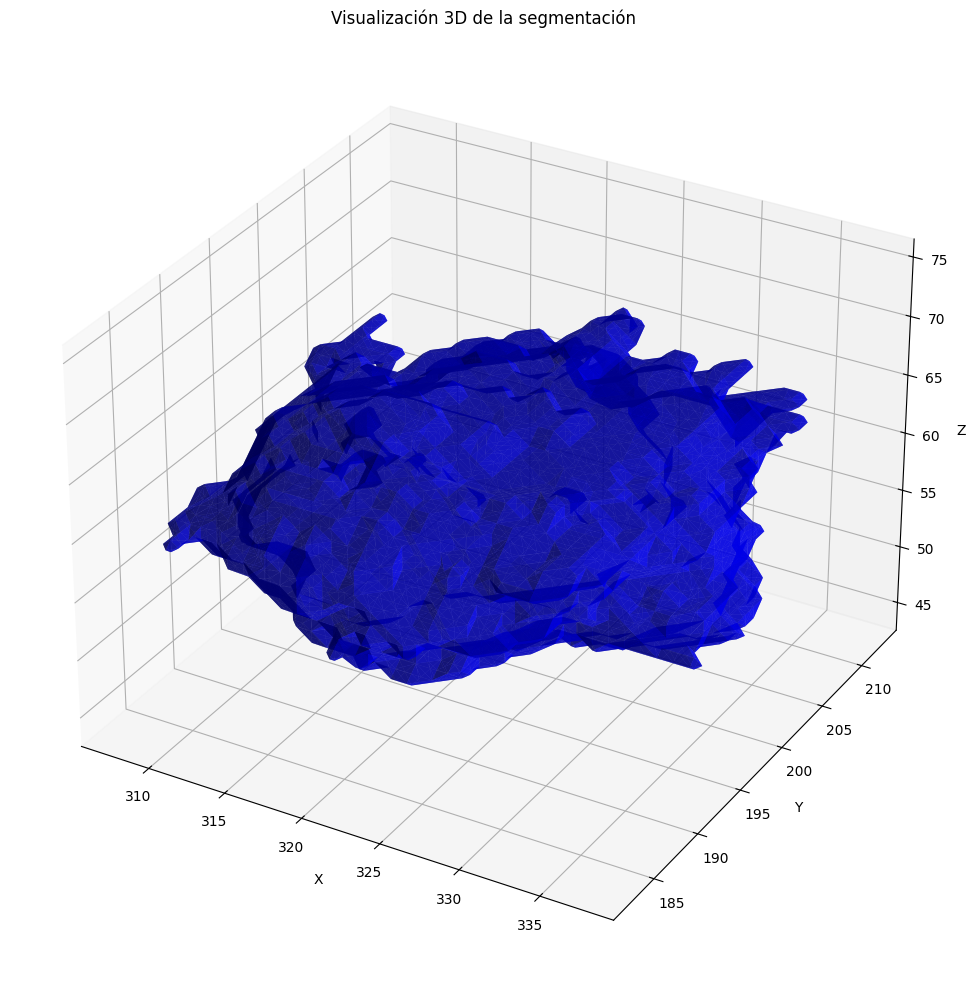

Generando visualización 3D de la segmentación...


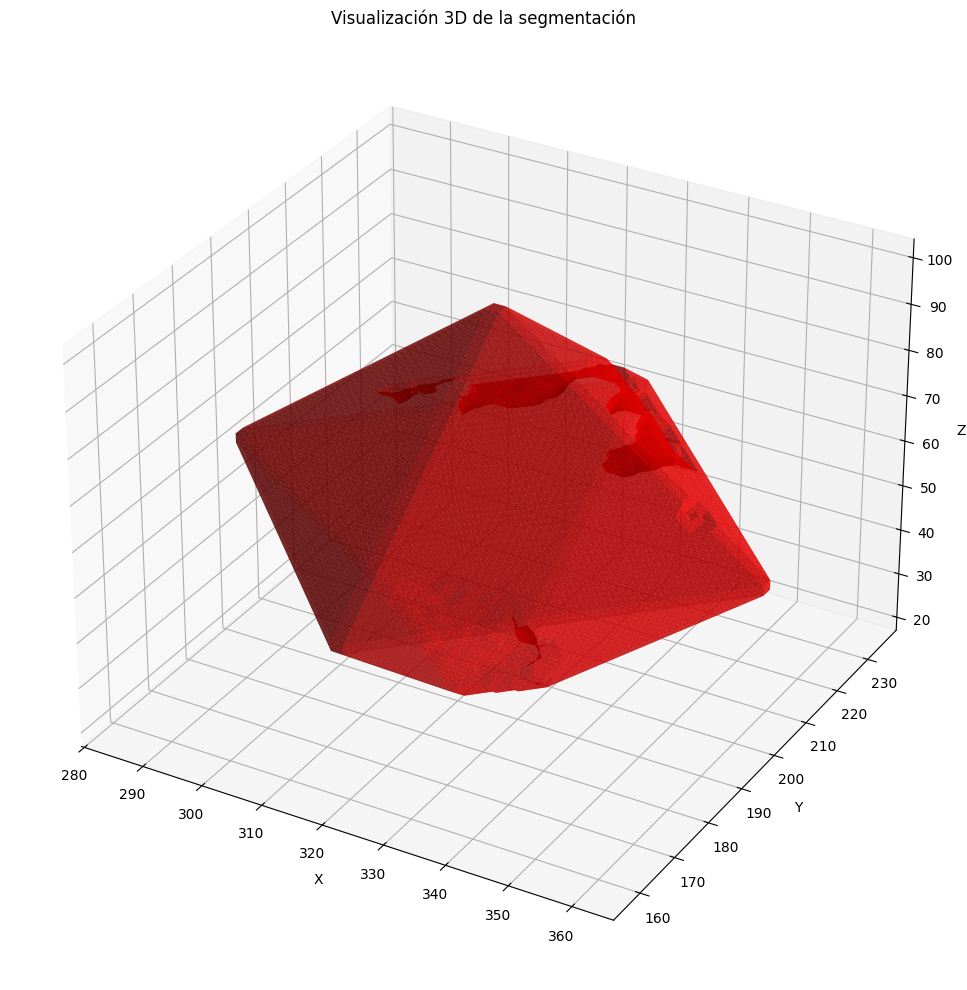


Métricas de evaluación 3D:
Dice: 0.1153
IoU: 0.0612
Precision: 0.0612
Recall: 1.0000


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import nibabel as nib
from skimage import measure
from scipy import ndimage
import time

# 1. Cargar imagen y máscara como volúmenes 3D
ruta_img = 'datos/images/duke_001_0000.nii.gz'
ruta_mask = 'datos/segmentations/expert/duke_001.nii.gz'

# Cargar los datos completos en 3D
img_nib = nib.load(ruta_img)
mask_nib = nib.load(ruta_mask)

img_3d = img_nib.get_fdata()
mask_3d = mask_nib.get_fdata()

print(f"Dimensiones del volumen de imagen: {img_3d.shape}")
print(f"Dimensiones del volumen de máscara: {mask_3d.shape}")

# 2. Visualizar slices en los tres planos ortogonales
def mostrar_slices_ortogonales(volumen, mascara, slice_indices=None):
    """Visualiza slices de un volumen 3D en los tres planos ortogonales"""
    if slice_indices is None:
        # Si no se proporcionan índices, tomar el centro del volumen
        x, y, z = [s // 2 for s in volumen.shape]
    else:
        x, y, z = slice_indices
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plano axial (vista superior)
    axes[0].imshow(volumen[:, :, z], cmap='gray')
    axes[0].imshow(mascara[:, :, z], cmap='Reds', alpha=0.4)
    axes[0].set_title(f'Plano Axial (z={z})')
    axes[0].axis('off')
    
    # Plano coronal (vista frontal)
    axes[1].imshow(volumen[:, y, :].T, cmap='gray')
    axes[1].imshow(mascara[:, y, :].T, cmap='Reds', alpha=0.4)
    axes[1].set_title(f'Plano Coronal (y={y})')
    axes[1].axis('off')
    
    # Plano sagital (vista lateral)
    axes[2].imshow(volumen[x, :, :].T, cmap='gray')
    axes[2].imshow(mascara[x, :, :].T, cmap='Reds', alpha=0.4)
    axes[2].set_title(f'Plano Sagital (x={x})')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Encontrar un slice con tumor para visualizar
tumor_slices_z = [z for z in range(mask_3d.shape[2]) if np.sum(mask_3d[:, :, z]) > 0]
if tumor_slices_z:
    z_tumor = tumor_slices_z[len(tumor_slices_z)//2]  # Tomar un slice central con tumor
    # Encontrar coordenadas centrales del tumor en ese slice
    tumor_mask = mask_3d[:, :, z_tumor] > 0
    labeled_mask, _ = ndimage.label(tumor_mask)
    objects = ndimage.find_objects(labeled_mask)
    if objects:
        # Tomar el centro del primer objeto tumor
        y_min, y_max = objects[0][0].start, objects[0][0].stop
        x_min, x_max = objects[0][1].start, objects[0][1].stop
        y_tumor = (y_min + y_max) // 2
        x_tumor = (x_min + x_max) // 2
    else:
        y_tumor, x_tumor = mask_3d.shape[0]//2, mask_3d.shape[1]//2
else:
    # Si no hay tumor, mostrar slices centrales
    z_tumor = mask_3d.shape[2]//2
    y_tumor = mask_3d.shape[0]//2
    x_tumor = mask_3d.shape[1]//2

# Mostrar slices ortogonales que atraviesan el tumor
mostrar_slices_ortogonales(img_3d, mask_3d, (x_tumor, y_tumor, z_tumor))

# 3. Implementar un algoritmo de segmentación 3D basado en crecimiento de regiones
def segmentacion_region_3d(imagen, semilla, umbral_bajo, umbral_alto):
    """
    Segmenta un volumen 3D usando crecimiento de regiones.
    
    Parámetros:
    - imagen: volumen 3D a segmentar
    - semilla: coordenadas (x, y, z) para comenzar la segmentación
    - umbral_bajo: valor mínimo para incluir un voxel
    - umbral_alto: valor máximo para incluir un voxel
    
    Retorna:
    - mascara: volumen binario con la segmentación
    """
    # Inicializar máscara de segmentación
    mascara = np.zeros_like(imagen, dtype=bool)
    
    # Obtener valor de intensidad en la semilla
    valor_semilla = imagen[semilla]
    
    # Inicializar lista de voxels a procesar
    por_procesar = [semilla]
    
    # Direcciones de vecinos (6-conectividad)
    direcciones = [
        (1, 0, 0), (-1, 0, 0),
        (0, 1, 0), (0, -1, 0),
        (0, 0, 1), (0, 0, -1)
    ]
    
    # Dimensiones del volumen
    dims = imagen.shape
    
    # Iniciar cronómetro
    inicio = time.time()
    
    # Procesar voxels
    mientras_haya_voxels = True
    while mientras_haya_voxels:
        if len(por_procesar) == 0:
            mientras_haya_voxels = False
            continue
            
        # Obtener próximo voxel a procesar
        x, y, z = por_procesar.pop(0)
        
        # Si ya fue procesado, continuar
        if mascara[x, y, z]:
            continue
        
        # Marcar como procesado
        mascara[x, y, z] = True
        
        # Revisar vecinos
        for dx, dy, dz in direcciones:
            nx, ny, nz = x + dx, y + dy, z + dz
            
            # Verificar que esté dentro de los límites
            if (0 <= nx < dims[0] and 0 <= ny < dims[1] and 0 <= nz < dims[2]):
                # Si no ha sido procesado y cumple con los criterios de umbral
                if not mascara[nx, ny, nz]:
                    valor = imagen[nx, ny, nz]
                    if umbral_bajo <= valor <= umbral_alto:
                        por_procesar.append((nx, ny, nz))
        
        # Verificar tiempo (límite de 30 segundos)
        if time.time() - inicio > 30:
            print("Tiempo límite alcanzado (30s)")
            break
    
    return mascara

# 4. Técnicas de pre y post-procesamiento para segmentación 3D
def preprocesar_volumen(volumen):
    """
    Preprocesa el volumen para mejorar la segmentación.
    """
    # Normalizar el volumen
    vol_norm = (volumen - np.min(volumen)) / (np.max(volumen) - np.min(volumen))
    
    # Aplicar filtro de suavizado gaussiano
    vol_suavizado = ndimage.gaussian_filter(vol_norm, sigma=1.0)
    
    return vol_suavizado

def postprocesar_mascara(mascara):
    """
    Postprocesa la máscara de segmentación.
    """
    # Rellenar huecos
    mascara_rellena = ndimage.binary_fill_holes(mascara)
    
    # Eliminar pequeños objetos (ruido)
    mascara_limpia = ndimage.binary_opening(mascara_rellena, structure=np.ones((3,3,3)))
    
    # Obtener el componente conectado más grande
    etiquetas, num_etiquetas = ndimage.label(mascara_limpia)
    if num_etiquetas > 0:
        conteos = np.bincount(etiquetas.flatten())
        # Ignorar la etiqueta 0 (fondo)
        if len(conteos) > 1:
            etiqueta_max = np.argmax(conteos[1:]) + 1
            mascara_final = (etiquetas == etiqueta_max)
        else:
            mascara_final = mascara_limpia
    else:
        mascara_final = mascara_limpia
    
    return mascara_final

# 5. Aplicar el algoritmo de segmentación 3D
# Preprocesar imagen
img_preprocesada = preprocesar_volumen(img_3d)

# Obtener un punto semilla del tumor (utilizamos una coordenada de la máscara)
indices_tumor = np.argwhere(mask_3d > 0)
if len(indices_tumor) > 0:
    # Seleccionar un punto medio del tumor como semilla
    semilla = tuple(indices_tumor[len(indices_tumor)//2])
    
    # Determinar umbrales basados en la intensidad de la semilla
    valor_semilla = img_preprocesada[semilla]
    umbral_bajo = valor_semilla - 0.1
    umbral_alto = valor_semilla + 0.1
    
    print(f"Usando semilla en {semilla} con valor {valor_semilla:.4f}")
    print(f"Umbrales: [{umbral_bajo:.4f}, {umbral_alto:.4f}]")
    
    # Realizar segmentación
    print("Iniciando segmentación 3D...")
    segmentacion = segmentacion_region_3d(img_preprocesada, semilla, umbral_bajo, umbral_alto)
    
    # Postprocesar resultado
    segmentacion_final = postprocesar_mascara(segmentacion)
    
    print(f"Segmentación completada. Volumen: {np.sum(segmentacion_final)} voxels")
    
    # Visualizar resultado
    mostrar_slices_ortogonales(img_3d, segmentacion_final, semilla)
    
    # 6. Visualización 3D de la segmentación usando malla de superficie
    def visualizar_superficie_3d(mascara, color='red', opacidad=0.5):
        """Crear visualización 3D de la superficie del objeto segmentado"""
        # Extraer malla de superficie usando marching cubes
        verts, faces, _, _ = measure.marching_cubes(mascara, 0.5)
        
        # Crear figura 3D
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Visualizar superficie
        mesh = ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2],
                            triangles=faces, color=color, alpha=opacidad)
        
        # Configurar ejes
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('Visualización 3D de la segmentación')
        
        # Ajustar visualización
        max_range = np.array([verts[:, 0].max() - verts[:, 0].min(),
                            verts[:, 1].max() - verts[:, 1].min(),
                            verts[:, 2].max() - verts[:, 2].min()]).max() / 2.0
        
        mid_x = (verts[:, 0].max() + verts[:, 0].min()) * 0.5
        mid_y = (verts[:, 1].max() + verts[:, 1].min()) * 0.5
        mid_z = (verts[:, 2].max() + verts[:, 2].min()) * 0.5
        
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)
        
        plt.tight_layout()
        plt.show()
        
    # Visualizar superficie 3D de la máscara real
    print("Generando visualización 3D de la máscara real...")
    visualizar_superficie_3d(mask_3d, color='blue', opacidad=0.7)
    
    # Visualizar superficie 3D de la segmentación obtenida
    print("Generando visualización 3D de la segmentación...")
    visualizar_superficie_3d(segmentacion_final, color='red', opacidad=0.7)
    
    # 7. Métricas de evaluación para segmentación 3D
    def calcular_metricas_3d(mascara_real, mascara_pred):
        """Calcula métricas de evaluación para segmentación 3D"""
        # Calcular verdaderos positivos, falsos positivos, etc.
        vp = np.sum(mascara_real & mascara_pred)
        fp = np.sum((~mascara_real) & mascara_pred)
        fn = np.sum(mascara_real & (~mascara_pred))
        
        # Calcular métricas
        dice = (2.0 * vp) / (2.0 * vp + fp + fn + 1e-10)
        iou = vp / (vp + fp + fn + 1e-10)
        precision = vp / (vp + fp + 1e-10)
        recall = vp / (vp + fn + 1e-10)
        
        return {
            'Dice': dice,
            'IoU': iou,
            'Precision': precision,
            'Recall': recall
        }
    
    # Evaluar segmentación contra máscara real
    mascara_pred_bin = segmentacion_final > 0
    mascara_real_bin = mask_3d > 0
    
    metricas = calcular_metricas_3d(mascara_real_bin, mascara_pred_bin)
    
    print("\nMétricas de evaluación 3D:")
    for nombre, valor in metricas.items():
        print(f"{nombre}: {valor:.4f}")
else:
    print("No se encontraron regiones con tumor en la máscara de referencia")

# monai